## Descarga de datos históricos de Bancolombia ADR (CIB)

En esta celda se utiliza la librería `yfinance` para descargar el historial de precios de apertura del ADR de Bancolombia (símbolo "CIB") desde el 11 de mayo de 2015 hasta el 9 de mayo de 2025. Luego, se filtra únicamente la columna **Open** (precio de apertura) y se reinicia el índice para que la columna de fechas quede como una columna regular del DataFrame.


In [1]:
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt

# ---------------------------
# 1) Descargar precios de CIB
# ---------------------------
TICKER = "CIB"
START = "2020-01-01"
END = "2025-09-12"

print(f"Descargando {TICKER} desde {START} hasta {END} ...")
df_raw = yf.download(TICKER, start=START, end=END)

if df_raw is None or df_raw.empty:
    raise RuntimeError("No se descargaron datos. Revisa el ticker o la conexión a internet.")

# Extraer columna 'Open' y asegurar formato correcto
df_model = df_raw[['Open']].copy()
df_model = df_model.reset_index()  # Elimina MultiIndex si existe
df_model.columns = df_model.columns.get_level_values(0)  # Asegura que no haya niveles ocultos
df_model.rename(columns={'Date': 'fecha'}, inplace=True)
df_model['fecha'] = pd.to_datetime(df_model['fecha']).dt.date  # Convertir a solo fecha (sin hora)

print("✅ Precios preparados:", df_model.dtypes)

# ---------------------------
# 2) Cargar y preparar noticias
# ---------------------------
ruta_excel = "C:/Users/Usuario/Documents/especializacion/monografia/segunda entrega/noticias_banco_con_sentimiento.xlsx"
df_noticias = pd.read_excel(ruta_excel)

# Asegurar formato de fecha
df_noticias['fecha'] = pd.to_datetime(df_noticias['fecha'], errors='coerce')
df_noticias['fecha'] = df_noticias['fecha'].dt.date

# Eliminar fechas inválidas
if df_noticias['fecha'].isnull().any():
    print("⚠️ Hay fechas no válidas en las noticias.")
    df_noticias = df_noticias.dropna(subset=['fecha'])

# ---------------------------
# 3) Agrupar sentimiento promedio por día
# ---------------------------
df_sentimientos = (
    df_noticias.groupby('fecha')['sentimiento_estrellas']
    .mean()
    .reset_index()
    .rename(columns={'sentimiento_estrellas': 'sentimiento_promedio'})
)

print("✅ Sentimiento preparado:", df_sentimientos.dtypes)

# ---------------------------
# 4) Hacer merge (join) con precios
# ---------------------------
# Asegurar que ambas columnas 'fecha' sean tipo `object` (date)
df_model['fecha'] = pd.to_datetime(df_model['fecha']).dt.date
df_sentimientos['fecha'] = pd.to_datetime(df_sentimientos['fecha']).dt.date

# Ahora sí, hacer el merge
df_merged = pd.merge(df_model, df_sentimientos, on='fecha', how='left')

# ---------------------------
# 5) Imputar NaNs en 'sentimiento_promedio'
# ---------------------------

df_merged['sentimiento_promedio'] = df_merged['sentimiento_promedio'].astype(float)
prev = df_merged['sentimiento_promedio'].ffill()
next = df_merged['sentimiento_promedio'].bfill()
df_merged['sentimiento_promedio'] = df_merged['sentimiento_promedio'].combine_first((prev + next) / 2)
df_merged['sentimiento_promedio'] = df_merged['sentimiento_promedio'].round(2)

# 6) Eliminar la fecha 2020-01-02
df_merged = df_merged[df_merged['fecha'] != pd.to_datetime("2020-01-02").date()]

# 7) Mostrar y guardar
print(df_merged.head())
# df_merged.to_csv("precios_con_sentimiento.csv", index=False)
# print("✅ Archivo guardado como 'precios_con_sentimiento.csv' sin el 2020-01-02")




# ---------------------------
# 2) Parámetros train/test y ventanas
# ---------------------------
TEST_DAYS = 30
WINDOW = 6
target_col = 'Open'  # <- ya definido

# Usamos el dataset df_merged
df_model = df_merged.copy()

# Verificación de columnas
if 'sentimiento_promedio' not in df_model.columns:
    raise ValueError("La columna 'sentimiento_promedio' no está presente en el dataset.")

# Aseguramos que las columnas relevantes sean numéricas
df_model[['Open', 'sentimiento_promedio']] = df_model[['Open', 'sentimiento_promedio']].astype(float)

# Verificamos que haya suficientes datos
if len(df_model) <= WINDOW + TEST_DAYS:
    raise ValueError(f"Pocos datos: necesitas > {WINDOW+TEST_DAYS} filas. Actualmente tienes {len(df_model)}.")

# Separar train/test
train_df = df_model.iloc[:-TEST_DAYS].copy()
test_df = df_model.iloc[-TEST_DAYS:].copy()
print("Filas totales:", len(df_model), "→ train:", len(train_df), " test:", len(test_df))

# ---------------------------
# 3) Escalado
# ---------------------------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Variables exógenas (features)
features = ['Open', 'sentimiento_promedio']

X_train_all = train_df[features].values
scaler_X.fit(X_train_all)

# Target
y_train_all = train_df[[target_col]].values
scaler_y.fit(y_train_all)

# Escalar todo el dataset
df_scaled = pd.DataFrame(
    scaler_X.transform(df_model[features]),
    index=df_model.index,
    columns=features
)

# Escalar target por separado
target_scaled = pd.Series(
    scaler_y.transform(df_model[[target_col]]).flatten(),
    index=df_model.index,
    name=target_col
)


Descargando CIB desde 2020-01-01 hasta 2025-09-12 ...


C:\Users\Usuario\AppData\Local\Temp\ipykernel_19644\2907410920.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download(TICKER, start=START, end=END)
[*********************100%***********************]  1 of 1 completed


✅ Precios preparados: Price
fecha     object
Open     float64
dtype: object
✅ Sentimiento preparado: fecha                    object
sentimiento_promedio    float64
dtype: object
        fecha       Open  sentimiento_promedio
1  2020-01-03  29.399070                  5.00
2  2020-01-06  29.382980                  3.00
3  2020-01-07  29.554598                  3.00
4  2020-01-08  29.726208                  4.33
5  2020-01-09  30.010434                  2.67
Filas totales: 1430 → train: 1400  test: 30


c:\Users\Usuario\anaconda3\envs\stats\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Users\Usuario\anaconda3\envs\stats\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [2]:
# ---------------------------
# 4) Crear secuencias (ventana deslizante)
# ---------------------------
def create_sequences(scaled_df, scaled_target_series, start_idx, end_idx, window):
    X, y = [], []
    for i in range(start_idx + window, end_idx):
        seq_X = scaled_df.iloc[i-window:i].values
        seq_y = scaled_target_series.iloc[i]
        X.append(seq_X)
        y.append(seq_y)
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    return X, y

N = len(df_scaled)
train_end_idx = len(train_df)

X_train, y_train = create_sequences(df_scaled.iloc[:train_end_idx], target_scaled.iloc[:train_end_idx], 0, train_end_idx, WINDOW)
print("X_train shape:", X_train.shape, " y_train shape:", y_train.shape)

X_test, y_test = create_sequences(df_scaled, target_scaled, train_end_idx - WINDOW, N, WINDOW)
print("X_test shape:", X_test.shape, " y_test shape:", y_test.shape, f"(esperado: ~{TEST_DAYS} filas)")

X_train shape: (1394, 6, 2)  y_train shape: (1394, 1)
X_test shape: (30, 6, 2)  y_test shape: (30, 1) (esperado: ~30 filas)


In [3]:
# --------------------------- 
# 5) Keras Tuner: build_model(hp) y búsqueda Hyperband (versión RNN)
# ---------------------------
def build_model(hp):
    """
    Define el espacio de búsqueda para Hyperband.
    - hp_units: unidades RNN
    - hp_layers: número de capas RNN (1 a 3)
    - hp_lr: learning rate
    - hp_dropout: dropout rate
    """
    model = Sequential()
    hp_units = hp.Int("units", min_value=32, max_value=80, step=16)
    hp_layers = hp.Int("layers", min_value=1, max_value=3, step=1)
    hp_lr = hp.Choice("learning_rate", values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])
    hp_dropout = hp.Float("dropout", min_value=0.0, max_value=0.3, step=0.1)

    for i in range(hp_layers):
        return_seq = (i < hp_layers - 1)
        if i == 0:
            model.add(SimpleRNN(
                units=hp_units,
                return_sequences=return_seq,
                input_shape=(WINDOW, X_train.shape[2])
            ))
        else:
            model.add(SimpleRNN(
                units=hp_units,
                return_sequences=return_seq
            ))

        if hp_dropout > 0:
            model.add(Dropout(hp_dropout))

    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=hp_lr), loss='mse', metrics=['mae'])
    return model


# Decide si ejecutar búsqueda o usar modelo manual
use_tuner = True

if use_tuner:
    tuner = kt.Hyperband(
        build_model,
        objective='val_loss',
        max_epochs=30,
        factor=3,
        directory='kt_dir_sentimiento_rnn',
        project_name='rnn_multivar_hyperband'
    )

    print("Iniciando búsqueda de hiperparámetros con Keras Tuner (Hyperband) para RNN...")
    tuner.search(
        X_train, y_train,
        epochs=30,
        validation_split=0.10,
        shuffle=False,
        batch_size=32,
        verbose=2
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Mejores HPs encontrados:", best_hps.values)

    model = tuner.hypermodel.build(best_hps)
    history = model.fit(
        X_train, y_train,
        validation_split=0.10,
        epochs=25,
        batch_size=32,
        shuffle=False,
        verbose=2
    )

else:
    tf.keras.backend.clear_session()
    model = Sequential([
        SimpleRNN(64, return_sequences=True, input_shape=(WINDOW, X_train.shape[2])),
        Dropout(0.1),
        SimpleRNN(64, return_sequences=False),
        Dropout(0.1),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
    es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_split=0.10,
        epochs=60,
        batch_size=32,
        callbacks=[es],
        shuffle=False,
        verbose=2
    )



Trial 90 Complete [00h 00m 10s]
val_loss: 0.010456761345267296

Best val_loss So Far: 0.0004898346960544586
Total elapsed time: 00h 08m 03s
Mejores HPs encontrados: {'units': 64, 'layers': 1, 'learning_rate': 0.005, 'dropout': 0.1, 'tuner/epochs': 30, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Epoch 1/25
40/40 - 2s - 45ms/step - loss: 0.0317 - mae: 0.1280 - val_loss: 0.0054 - val_mae: 0.0615
Epoch 2/25
40/40 - 0s - 5ms/step - loss: 0.0053 - mae: 0.0570 - val_loss: 0.0025 - val_mae: 0.0414
Epoch 3/25
40/40 - 0s - 5ms/step - loss: 0.0031 - mae: 0.0434 - val_loss: 0.0040 - val_mae: 0.0542
Epoch 4/25
40/40 - 0s - 5ms/step - loss: 0.0029 - mae: 0.0425 - val_loss: 0.0019 - val_mae: 0.0356
Epoch 5/25
40/40 - 0s - 5ms/step - loss: 0.0023 - mae: 0.0377 - val_loss: 0.0018 - val_mae: 0.0346
Epoch 6/25
40/40 - 0s - 5ms/step - loss: 0.0018 - mae: 0.0335 - val_loss: 0.0017 - val_mae: 0.0340
Epoch 7/25
40/40 - 0s - 5ms/step - loss: 0.0019 - mae: 0.0350 - val_loss: 0.0012 - val_ma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
----- Métricas (test) -----
MAE        : 1.646777 USD
RMSE       : 1.772661 USD
R2         : 0.5127
MAPE       : 3.351%
SMAPE      : 3.417%
MASE       : 4.6780
Dir Acc    : 41.38%
---------------------------


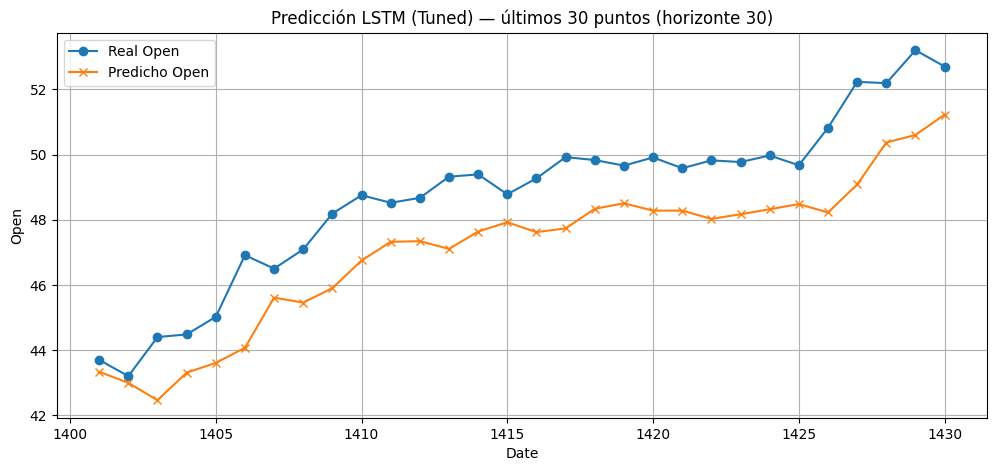

In [4]:
# ---------------------------
# 6) Predicción y evaluación sobre TEST  (REPARACIÓN para MASE)
# ---------------------------
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_true = scaler_y.inverse_transform(y_test).flatten()

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred))
    mask = denom == 0
    denom[mask] = np.nan
    res = 2.0 * np.abs(y_pred - y_true) / denom
    return np.nanmean(res) * 100.0

def mape(y_true, y_pred):
    denom = np.where(np.abs(y_true) == 0, np.nan, np.abs(y_true))
    return np.nanmean(np.abs((y_true - y_pred) / denom)) * 100.0

def mase(y_true, y_pred, train_series):
    """
    MASE = mean(|errors|) / MAE_naive_train
    train_series: pd.Series (serie original de entrenamiento en escala real)
    """
    # forzar que train_series sea Series 1-D numérica
    if isinstance(train_series, pd.DataFrame):
        # tomar la primera columna numérica si se pasa DataFrame por error
        numeric_cols = train_series.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) == 0:
            raise ValueError("train_series no contiene columnas numéricas.")
        ts = train_series[numeric_cols[0]].astype(float).copy()
    else:
        ts = pd.Series(train_series).astype(float).copy()

    # errores del test
    errors = np.abs(np.asarray(y_true) - np.asarray(y_pred))
    num = np.mean(errors)

    # denominador: MAE del naive one-step on train
    diffs = np.abs(ts.diff().dropna())
    if len(diffs) == 0:
        return np.nan
    denom_val = diffs.mean()  # esto debería ser escalar (numpy float)

    # forzar a float y comprobar
    try:
        denom = float(denom_val)
    except Exception:
        # si por alguna razón no se puede convertir, devolver NaN
        return np.nan

    # evitar división por cero
    if np.isnan(denom) or np.isclose(denom, 0.0):
        return np.nan

    return num / denom

# cálculo de métricas
mae_val = mean_absolute_error(y_true, y_pred)
rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
expl_var = explained_variance_score(y_true, y_pred)
mape_val = mape(y_true, y_pred)
smape_val = smape(y_true, y_pred)
mase_val = mase(y_true, y_pred, train_df[target_col])

def directional_accuracy(true_arr, pred_arr):
    if len(true_arr) < 2:
        return np.nan
    true_diff = np.sign(np.diff(true_arr))
    pred_diff = np.sign(np.diff(pred_arr))
    return np.mean(true_diff == pred_diff) * 100.0

dir_acc = directional_accuracy(y_true, y_pred)

print("----- Métricas (test) -----")
print(f"MAE        : {mae_val:.6f} USD")
print(f"RMSE       : {rmse_val:.6f} USD")
print(f"R2         : {r2:.4f}")
print(f"MAPE       : {mape_val:.3f}%")
print(f"SMAPE      : {smape_val:.3f}%")
print(f"MASE       : {mase_val if mase_val is not None else np.nan:.4f}")
print(f"Dir Acc    : {dir_acc:.2f}%")
print("---------------------------")

# ---------------------------
# 7) Graficar resultados (fechas)
# ---------------------------
test_start_idx = len(df_model) - TEST_DAYS
test_dates = df_model.index[test_start_idx : test_start_idx + len(y_true)]

plt.figure(figsize=(12,5))
plt.plot(test_dates, y_true, marker='o', label='Real ' + target_col)
plt.plot(test_dates, y_pred, marker='x', label='Predicho ' + target_col)
plt.title(f"Predicción LSTM (Tuned) — últimos {len(y_true)} puntos (horizonte {TEST_DAYS})")
plt.xlabel("Date")
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.show()


In [5]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 80)             │        20,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,725 (237.21 KB)

 Trainable params: 20,241 (79.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,484 (158.14 KB)

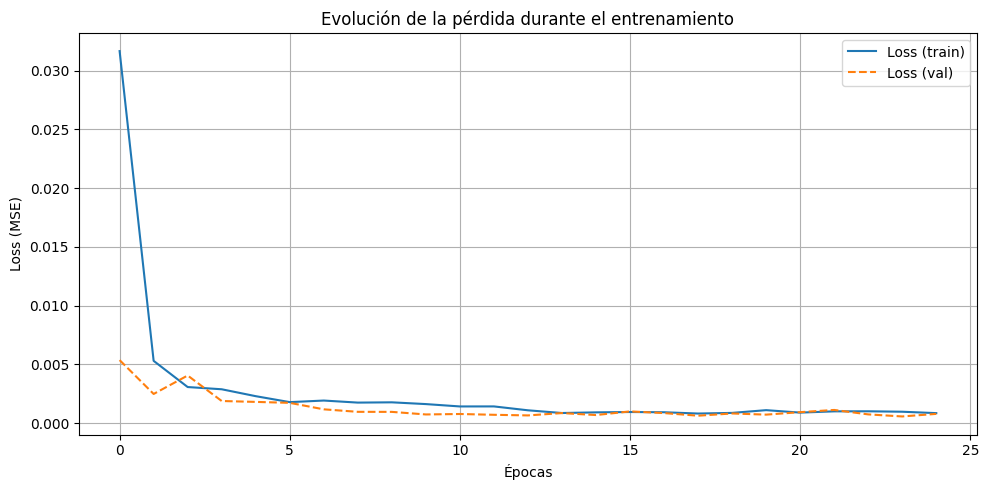

In [5]:
import matplotlib.pyplot as plt

# Graficar pérdida de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (val)', linestyle='--')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()